In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
import torch

## Tobit

In [44]:
def tobit(y, y_hat, yL = 15, sigma=2):
    indicator = int(y < yL)
    return ((1/sigma * norm.pdf((y-y_hat)/sigma))**indicator) * (norm.cdf((y_hat - yL)/sigma))**(1-indicator)

In [45]:
y_hat = np.linspace(0.01, 50, num=100) # Embedding distance

In [46]:
L_pos = tobit(10, y_hat)
L_neg = tobit(50, y_hat)

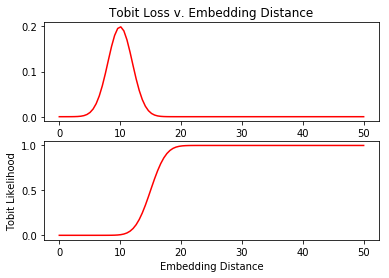

In [47]:
fig, ax = plt.subplots(2, 1)
ax[0].set_title('Tobit Loss v. Embedding Distance')
ax[0].plot(y_hat,L_pos,'r-')
ax[1].set_xlabel('Embedding Distance')
ax[1].set_ylabel('Tobit Likelihood')
ax[1].plot(y_hat, L_neg,'r-')

Thoughts: 
* Using embedding distances up to 50, but usually they are < 1. 

* Shouldn't the top graph be flipped upside down? If we try to minimize this, we will "push" away points > 10. 

* On the bottom graph, if a negative point is REALLY close, the gradient will be quite small right? The biggest gradient is actually until x = 25, which is the threshold. Is that ideal? It could also happen if sigma is not scaled large enough.





In [17]:
NUM_POINTS = 50
y_hat = np.linspace(1, 50, num=NUM_POINTS) # Embedding distance
y = np.linspace(1, 50, num=NUM_POINTS)     # GPS distance
tobit_likelihood = np.ones((NUM_POINTS, NUM_POINTS))
for i in range(NUM_POINTS):
    tobit_likelihood[i,:] = tobit(y[i], y_hat)

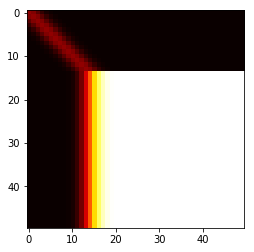

In [18]:
plt.imshow(tobit_likelihood, cmap='hot', interpolation='nearest')
plt.show()

- White area: High Likelihood
- Red/Yellow: Medium Likelihood
- Black area: Low Likelihood 

## Contrastive

In [2]:
def contrastive(y, y_hat, yL = 25, margin_thr=0.7):
    indicator = int(y > yL) # => Postive point
    margin = np.full(len(y_hat), margin_thr)
    return ((1-indicator) * 1/2 * y_hat**2) + indicator*1/2*((margin-y_hat).clip(min=0))**2

In [48]:
NUM_POINTS = 1000
Dw = np.linspace(0.01, 2, num=NUM_POINTS) # Embedding Distances

In [49]:
L_Pos = contrastive(10, Dw)
L_Neg = contrastive(50, Dw)

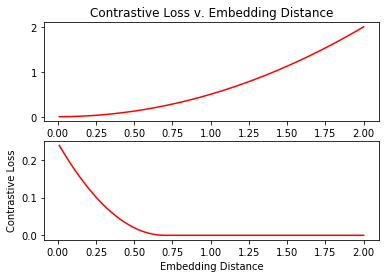

In [50]:
fig, ax = plt.subplots(2, 1)
ax[0].set_title('Contrastive Loss v. Embedding Distance')
ax[0].plot(Dw, L_Pos,'r-')
#ax[0].ylim((0, 1))
ax[1].set_xlabel('Embedding Distance')
ax[1].set_ylabel('Contrastive Loss')
ax[1].plot(Dw, L_Neg,'r-')

In [51]:
NUM_POINTS = 10
y_hat = np.linspace(1, 2, num=NUM_POINTS)- 1 # Embedding distance
y = np.linspace(0.001, 50, num=NUM_POINTS)   # GPS distance
contrastive_loss = np.ones((NUM_POINTS, NUM_POINTS))
print(y_hat)
for i in range(NUM_POINTS):
    contrastive_loss[i,:] = contrastive(y[i], y_hat)

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]


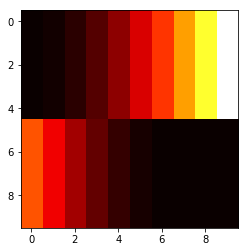

In [52]:
plt.imshow(contrastive_loss, cmap='hot', interpolation='nearest')
plt.show()

## Scaled Contrastive

In [31]:
def scaled_contrastive(y, y_hat, yL = 25, margin_thr=0.7):
    indicator = int(y > yL) # => Postive point
    margin = np.full(len(y_hat), margin_thr)
    peak = margin_thr / yL * y
    return ((1-indicator) * 4 * (y_hat - peak)**2) + indicator*4*((margin-y_hat).clip(min=0))**2

In [32]:
NUM_POINTS = 1000
Dw = np.linspace(0.01, 1, num=NUM_POINTS) # Embedding Distances

In [33]:
L_Pos = scaled_contrastive(10, Dw)
L_Neg = scaled_contrastive(50, Dw)

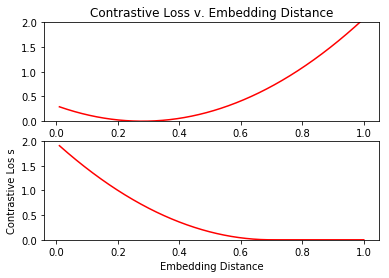

In [34]:
fig, ax = plt.subplots(2, 1)
ax[0].set_ylim(0, 2)
ax[0].set_title('Contrastive Loss v. Embedding Distance')
ax[0].plot(Dw, L_Pos,'r-')
ax[1].set_ylim(0, 2)
ax[1].set_xlabel('Embedding Distance')
ax[1].set_ylabel('Contrastive Los s')
ax[1].plot(Dw, L_Neg,'r-')

In [35]:
NUM_POINTS = 10
y_hat = np.linspace(1, 2, num=NUM_POINTS)- 1 # Embedding distance
y = np.linspace(0.001, 50, num=NUM_POINTS)   # GPS distance
contrastive_loss = np.ones((NUM_POINTS, NUM_POINTS))
for i in range(NUM_POINTS):
    contrastive_loss[i,:] = scaled_contrastive(y[i], y_hat)

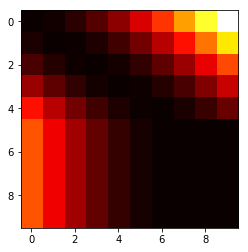

In [36]:
fig, ax = plt.subplots(1,1)
plt.imshow(contrastive_loss, cmap='hot', interpolation='nearest')
plt.show()

## Triplet

In [342]:
def triplet_loss(dp, dn, margin=0.5):
    return (dp-dn+margin).clip(min=0)

In [343]:
triplet_loss(np.array([5,5]),np.array([4,4]))

array([1.5, 1.5])

In [344]:
NUM_POINTS = 10

In [345]:
dp = np.linspace(0.1, 2, num=NUM_POINTS)
dn = np.linspace(0.1, 2, num=NUM_POINTS)

In [346]:
triplet = np.ones((NUM_POINTS, NUM_POINTS))
for i, pos in enumerate(dp):
    dpi = np.full(NUM_POINTS, pos)
    triplet[i,:] = triplet_loss(dpi, dn)

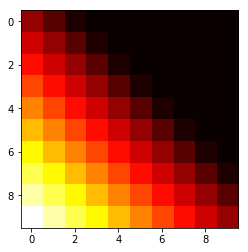

In [347]:
plt.imshow(triplet, cmap='hot', interpolation='nearest')
plt.show()

## Log Tobit

In [37]:
def log_tobit(y, y_hat, yL = 15, sigma=2):
    indicator = int(y < yL)
    #Tobit:       ((1/sigma * norm.pdf((y-y_hat)/sigma))**indicator) *     (norm.cdf((y_hat - yL)/sigma))**(1-indicator)
    return -np.log(1/sigma * norm.pdf((y-y_hat)/sigma))**indicator - np.log(norm.cdf((y_hat - yL)/sigma))**(1-indicator)

In [38]:
y_hat = np.linspace(0.01, 50, num=100) # Embedding distance
L_pos = log_tobit(10, y_hat)
L_neg = log_tobit(50, y_hat)

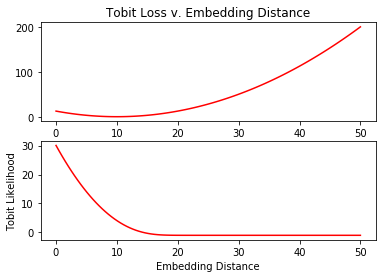

In [39]:
fig, ax = plt.subplots(2, 1)
ax[0].set_title('Tobit Loss v. Embedding Distance')
ax[0].plot(y_hat,L_pos,'r-')
ax[1].set_xlabel('Embedding Distance')
ax[1].set_ylabel('Tobit Likelihood')
ax[1].plot(y_hat, L_neg,'r-')

In [8]:
NUM_POINTS = 10
y_hat = np.linspace(1, 50, num=NUM_POINTS) # Embedding distance
y = np.linspace(1, 50, num=NUM_POINTS)     # GPS distance
tobit_likelihood = np.ones((NUM_POINTS, NUM_POINTS))
for i in range(NUM_POINTS):
    tobit_likelihood[i,:] = log_tobit(y[i], y_hat)

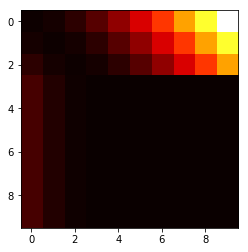

In [9]:
plt.imshow(tobit_likelihood, cmap='hot', interpolation='nearest')
plt.show()

### PyTorch 

In [10]:
import torch
import math

In [89]:
normal = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

In [90]:
torch.Tensor.ndim = property(lambda self: len(self.shape))

In [5]:
def log_tobit_torch(y, y_hat, yL = 15, sigma=1/4):
    scaling = 1#/15
    indicator = int(y < yL)
    return -np.log(1/sigma) - normal.log_prob((y-y_hat)/sigma)*indicator - torch.log(normal.cdf((y_hat - yL)/sigma)) * (1-indicator)

In [91]:
def log_tobit_torch(y, y_hat, yL = 15, sigma=1/4):
    scaling = 1 #/yL
    indicator = int(y < yL)
    if indicator == 1:
        return (np.log(1/sigma) + normal.log_prob((scaling*y-y_hat)/sigma))
    else:
        return -torch.log(normal.cdf((y_hat - yL*scaling)/sigma))

In [92]:
y_hat = torch.linspace(0.01, 2, steps=100) # Embedding distance
L_pos = log_tobit_torch(5, y_hat)
L_neg = log_tobit_torch(40, y_hat)

In [276]:
def log_tobit_torch(y, y_hat, yL = 15, sigma=1/2):
    scaling = 1/yL
    #indicator = int(y < yL)
    indicator = torch.tensor([1.0,0.0,0.0,0.0,0.0,0.0])
    inv_indicator = torch.tensor([0,1.0,1.0,1.0,1.0,1.0])
    #if indicator == 1:
         #- (math.log(1/sigma) + normal.log_prob((scaling*y-y_hat)/sigma) *lbl)
    return - (math.log(1/sigma) + normal.log_prob((scaling*y-y_hat)/sigma)) * indicator #- torch.log(normal.cdf((y_hat - yL*scaling)/sigma)) * inv_indicator
    #return - (math.log(1/sigma) + normal.log_prob((y*scaling-y_hat)/sigma)*indicator) - torch.log(normal.cdf((y_hat - yL*scaling)/sigma)) * inv_indicator
    #else:
    #    return -torch.log(normal.cdf((y_hat - yL*scaling)/sigma))
    #return -np.log(1/sigma) - normal.log_prob((y-y_hat)/sigma)*indicator - torch.log(normal.cdf((y_hat - yL)/sigma)) * (1-indicator)

In [281]:
y = 14.206073
D = torch.tensor([0.7247, 0.8282, 0.6296, 0.6339, 0.6391, 0.6446])
#tensor([1.6438, 1.5458, 1.5452, 1.5432, 1.5408, 1.5383]

In [282]:
log_tobit_torch(y,D)

tensor([0.3247, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

tensor([10.1922,  9.8585,  9.5306,  9.2096,  8.8942,  8.5851,  8.2822,  7.9853,
         7.6945,  7.4098])


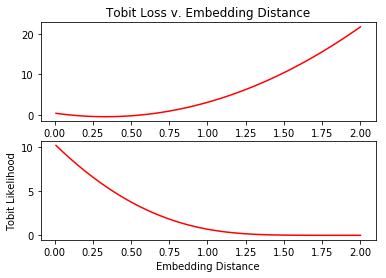

In [207]:
fig, ax = plt.subplots(2, 1)
ax[0].set_title('Tobit Loss v. Embedding Distance')
ax[0].plot(y_hat,L_pos,'r-')
ax[1].set_xlabel('Embedding Distance')
ax[1].set_ylabel('Tobit Likelihood')
ax[1].plot(y_hat, L_neg,'r-')
print(L_neg[0:10])

In [24]:
sigma = 1
dist = 1
D = 1
lbl = 1
gpsmargin = 15
scaling = 1/15

In [25]:
normal = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
log_tobit = - (math.log(1/sigma) + normal.log_prob((dist*scaling-D)/sigma)*lbl) - torch.log(normal.cdf((D - gpsmargin*scaling)/sigma)) * (1-lbl)

TypeError: 'float' object cannot be interpreted as an integer

## CDF Loss 

In [4]:
def cdf(y, y_hat, yL = 15, sigma=1):
    indicator = int(y < yL)
    scaling = 1 /(yL * 2)
    return (norm.cdf((y_hat - yL*scaling)/sigma))**(indicator) * (1-norm.cdf((y_hat - yL*scaling)/sigma))**(1-indicator)

In [5]:
y_hat = np.linspace(0.01, 2, num=100) # Embedding distance
L_pos = cdf(10, y_hat)
L_neg = cdf(50, y_hat)

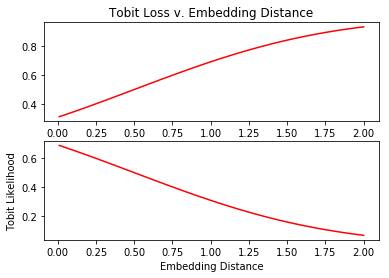

In [6]:
fig, ax = plt.subplots(2, 1)
ax[0].set_title('Tobit Loss v. Embedding Distance')
ax[0].plot(y_hat,L_pos,'r-')
ax[1].set_xlabel('Embedding Distance')
ax[1].set_ylabel('Tobit Likelihood')
ax[1].plot(y_hat, L_neg,'r-')

In [12]:
torch.Tensor.ndim = property(lambda self: len(self.shape))

In [23]:
def cdfloss(D, lbl, gpsmargin=15, sigma=1/2):
    normal = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([.5]))
    scaling = 1 / (gpsmargin * 2)
    return (normal.cdf((D - gpsmargin*scaling)/sigma))*lbl + (1-normal.cdf((D - gpsmargin*scaling)/sigma)) * (1-lbl)

In [24]:
y_hat = torch.linspace(0.01, 2, steps=100)
lbl = torch.ones(100)
L_pos = cdfloss(y_hat, lbl)
lbl = torch.zeros(100)
L_neg = cdfloss(y_hat, lbl)

In [25]:
y_hat[35]

tensor(0.7135)

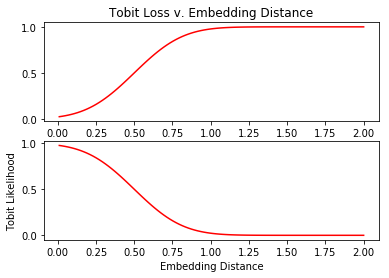

In [26]:
fig, ax = plt.subplots(2, 1)
ax[0].set_title('Tobit Loss v. Embedding Distance')
ax[0].plot(y_hat,L_pos,'r-')
ax[1].set_xlabel('Embedding Distance')
ax[1].set_ylabel('Tobit Likelihood')
ax[1].plot(y_hat, L_neg,'r-')

## Sigmoid 

In [145]:
def sigmoid(x, c1=10, c2=0.8):
    return 1 / (1+math.exp(-c1 * (x-c2)))

In [146]:
y_hat = np.linspace(0.01, 2, num=100) # Embedding distance
L = np.ones(100)
for i in range(100):
    L[i] = sigmoid(y_hat[i])

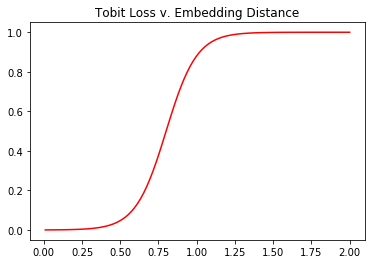

In [147]:
fig, ax = plt.subplots(1, 1)
ax.set_title('Tobit Loss v. Embedding Distance')
ax.plot(y_hat,L,'r-')